In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [164]:
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

from util.data import load_mnist, encode_data, add_noise
from util.plots import plot_images, plot_image
from util.metrics import (
    get_sp_stability,
    calc_noise_robustness,
    calculate_overlap,
    calculate_entropy,
)

from algorithms import SpatialPooler

<IPython.core.display.Javascript object>

In [3]:
(_, _), (x_test, y_test) = load_mnist()
x_test = encode_data(x_test)

<IPython.core.display.Javascript object>

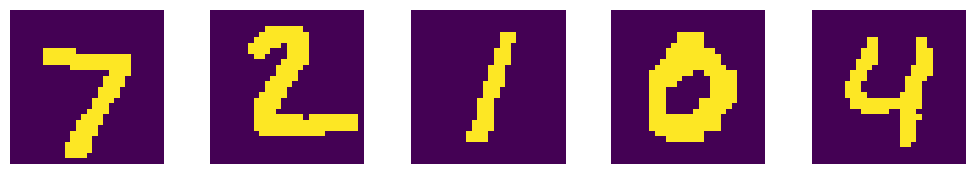

<IPython.core.display.Javascript object>

In [4]:
plot_images(x_test[:5])

In [5]:
sp = SpatialPooler(
    input_dimension=x_test[0].shape,
    column_dimension=(45, 45),
    connection_sparsity=0.7,
    permanence_threshold=0.5,
    stimulus_threshold=10,
    permanence_increment=0.1,
    permanence_decrement=0.02,
    column_sparsity=0.02,
    potential_pool_radius=8,
    boost_strength=10,
)
sp.load_state("data/12-03-2022_22-58-09/sp.pkl")

<IPython.core.display.Javascript object>

<AxesSubplot:>

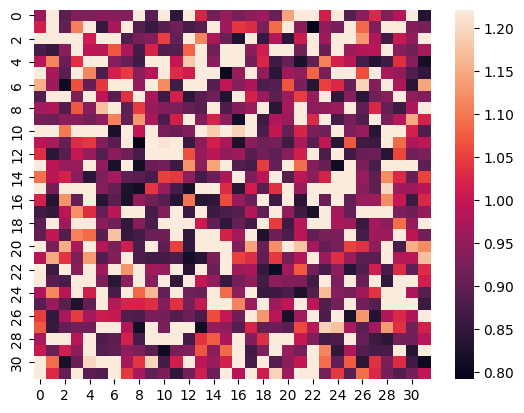

<IPython.core.display.Javascript object>

In [72]:
sns.heatmap(sp.boost_factors.reshape(32, 32))

<AxesSubplot:>

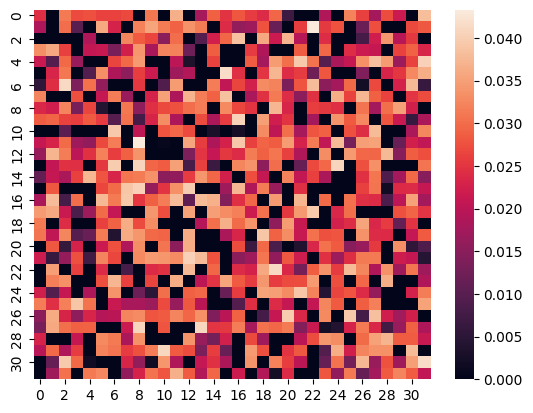

<IPython.core.display.Javascript object>

In [73]:
sns.heatmap(sp.active_duty_cycle.reshape((32, 32)))

<AxesSubplot:>

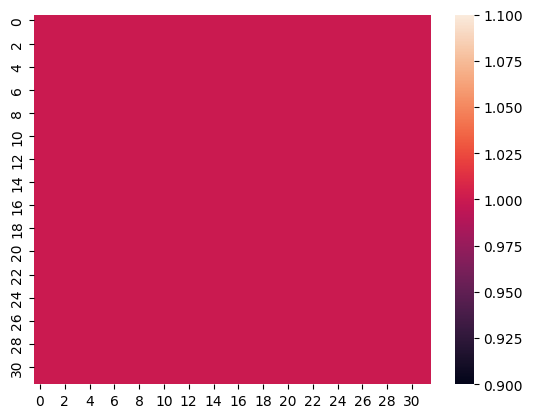

<IPython.core.display.Javascript object>

In [74]:
sns.heatmap(sp.overlap_duty_cycles.reshape((32, 32)))

In [78]:
sp.permanences[500:510].shape

(10, 784)

<IPython.core.display.Javascript object>

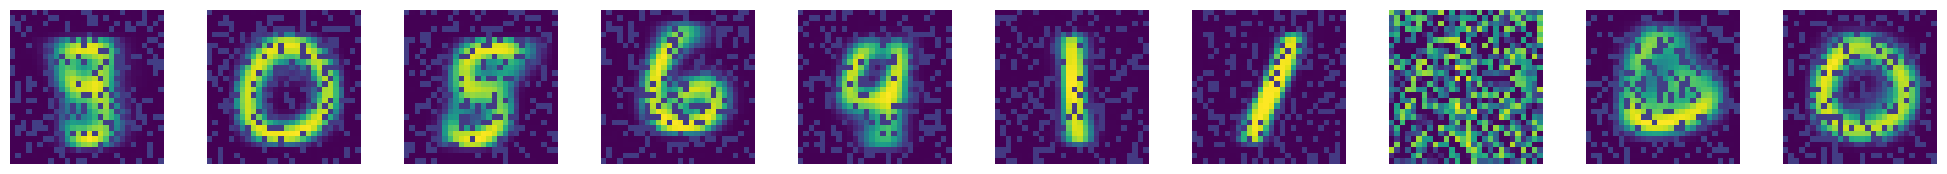

<IPython.core.display.Javascript object>

In [81]:
plot_images(sp.permanences[600:610].reshape((10, 28, 28)))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 131.25it/s]


<AxesSubplot:>

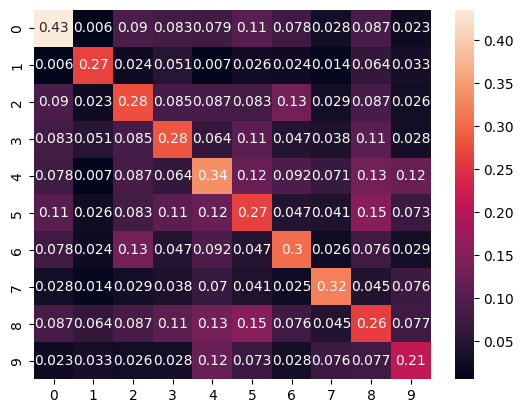

<IPython.core.display.Javascript object>

In [76]:
stability = get_sp_stability(sp, x_test.reshape((10000, 784)), y_test)
sns.heatmap(stability, annot=True)

In [156]:
noise_test = x_test[1].flatten()

noise_lvs = [n / 10000 for n in range(1, 10000)]

wc = sp.compute(noise_test, learn=False)
sdr = sp.top_columns_to_sdr(wc)

no_on_bits_sdr = len(wc)

shared_bits_fracs = []

for k in tqdm(noise_lvs):
    noisy_img = add_noise(noise_test, k)
    noisy_wc = sp.compute(noisy_img, learn=False)
    noisy_sdr = sp.top_columns_to_sdr(noisy_wc)

    overlap = calculate_overlap(sdr, noisy_sdr)

    shared_bits_frac = overlap / no_on_bits_sdr

    shared_bits_fracs.append(shared_bits_frac)

  0%|          | 0/9999 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<AxesSubplot:>

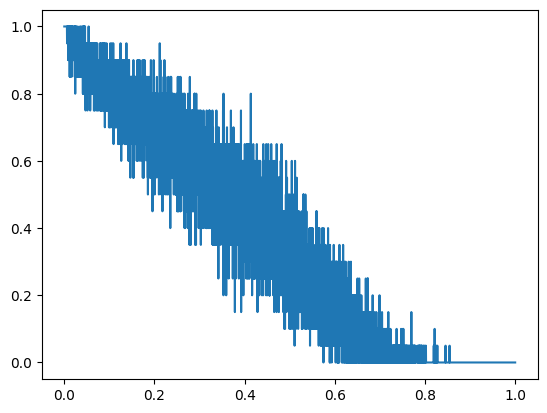

<IPython.core.display.Javascript object>

In [157]:
sns.lineplot(y=shared_bits_fracs, x=noise_lvs)

In [127]:
from scipy.signal import savgol_filter
from scipy.integrate import quad

<IPython.core.display.Javascript object>

<AxesSubplot:>

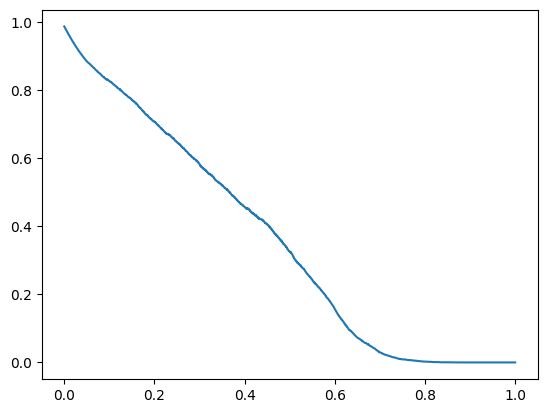

<IPython.core.display.Javascript object>

In [159]:
filter_val = savgol_filter(shared_bits_fracs, 1000, 2)
sns.lineplot(y=filter_val, x=[i / 10000 for i in range(0, 9999)])

In [161]:
areas = []
for idx in range(0, len(filter_val), 2):

    area = filter_val[idx] * 0.0001

    areas.append(area)

np.sum(areas)

0.1779794846775987

<IPython.core.display.Javascript object>

In [77]:
calc_noise_robustness(sp, x_test.reshape((10000, 784))[:5])

5it [00:45,  9.00s/it]


0.047156686334761125

<IPython.core.display.Javascript object>

In [172]:
calculate_entropy(sp, x_test.reshape((10000, 784)))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 232.16it/s]


0.11263589252389006

<IPython.core.display.Javascript object>